# Model Evaluation & Error Analysis

This notebook performs comprehensive evaluation of the trained invoice extraction models.

## Evaluation Framework
- **Precision, Recall, F1-score** per entity and overall
- **Error Analysis** with false positives/negatives identification
- **Cross-validation** results analysis
- **Post-processing** validation and normalization
- **Quality metrics** for production readiness

In [14]:
import sys, os, json, pickle, re
from typing import List, Dict, Any, Tuple
from datetime import datetime
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, f1_score

warnings.filterwarnings('ignore')
sys.path.append('..')
from extraction_service import InvoiceExtractor

print("✓ Evaluation notebook initialized")
print(f"✓ Working directory: {os.getcwd()}")

# %% [markdown]
## 0. Preload Class Definitions (for unpickling)

# %%
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

class IndonesianTokenizer:
    def __init__(self):
        self.currency_pattern = r'(?:Rp\.?|IDR|Rupiah)\s*[\d,\.]+'
        self.date_pattern     = r'\d{1,2}[\-/]\d{1,2}[\-/]\d{2,4}'
        self.npwp_pattern     = r'\d{2}\.\d{3}\.\d{3}\.\d{1}-\d{3}\.\d{3}'
        self.company_pattern  = r'(?:PT|CV|UD)\s+[A-Z\s]+'
        self.stopwords = {'dan','atau','yang','untuk','dengan','dari','pada','ke','di','dalam',
                          'adalah','akan','sudah','telah','dapat','harus','bisa','tidak','belum'}

    def tokenize(self, text: str) -> List[str]:
        special = []
        proc = text
        patterns = [
            (self.currency_pattern, 'CURRENCY_TOKEN'),
            (self.date_pattern,     'DATE_TOKEN'),
            (self.npwp_pattern,     'NPWP_TOKEN'),
            (self.company_pattern,  'COMPANY_TOKEN')
        ]
        for pat, typ in patterns:
            for m in re.finditer(pat, proc):
                ph = f'<{typ}_{len(special)}>'
                special.append((ph, m.group()))
                proc = proc.replace(m.group(), ph, 1)
        toks = re.findall(r'\b\w+\b|[^\w\s]', proc)
        for ph, orig in special:
            toks = [orig if t==ph else t for t in toks]
        return toks

    def preprocess_for_training(self, samples: List[Dict[str,Any]]
    ) -> Tuple[List[List[str]], List[List[str]]]:
        X, y = [], []
        for s in samples:
            toks = self.tokenize(s['text'])
            labs = s['labels'][:len(toks)]
            labs += ['O'] * (len(toks) - len(labs))
            X.append(toks); y.append(labs)
        return X, y

class LayoutAwareFeatureExtractor:
    def __init__(self):
        self.tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
        self.label_encoder = LabelEncoder()

    def extract_features(self, tokens: List[str], idx: int=0) -> Dict[str,float]:
        if idx>=len(tokens): return {}
        tok = tokens[idx]
        feats = {
            'token_length': len(tok),
            'is_numeric': float(tok.isdigit()),
            'is_alpha': float(tok.isalpha()),
            'is_alphanumeric': float(tok.isalnum()),
            'is_upper': float(tok.isupper()),
            'is_lower': float(tok.islower()),
            'is_title': float(tok.istitle()),
            'relative_position': idx/len(tokens),
            'is_beginning': float(idx<3),
            'is_end': float(idx>len(tokens)-3),
            'is_middle': float(0.3<=idx/len(tokens)<=0.7),
            'contains_digit': float(any(c.isdigit() for c in tok)),
            'contains_punct': float(any(c in '.,:-/\\' for c in tok)),
            'is_currency_like': float(re.match(r'.*[Rr]p.*|.*IDR.*|.*\d+[,\.]\d+.*', tok) is not None),
            'is_date_like': float(re.match(r'\d{1,2}[\-/]\d{1,2}[\-/]\d{2,4}', tok) is not None),
            'is_npwp_like': float(re.match(r'\d{2}\.\d{3}\.\d{3}\.\d{1}-\d{3}\.\d{3}', tok) is not None),
        }
        prev = tokens[idx-1] if idx>0 else ''
        nxt  = tokens[idx+1] if idx<len(tokens)-1 else ''
        feats.update({
            'prev_is_numeric':   float(prev.isdigit()),
            'prev_is_punct':     float(prev in '.,:-'),
            'next_is_numeric':   float(nxt.isdigit()),
            'next_is_punct':     float(nxt in '.,:-'),
            'is_indonesian_keyword': float(tok.lower() in 
                ['invoice','faktur','tagihan','pembayaran','total','jumlah','npwp','pajak'])
        })
        return feats

    def prepare_training_data(self, X_tokens: List[List[str]], y_labels: List[List[str]]
    ) -> Tuple[np.ndarray,np.ndarray]:
        feats, labs = [], []
        for toks, lbls in zip(X_tokens, y_labels):
            for i, lab in enumerate(lbls):
                fd = self.extract_features(toks, i)
                feats.append(list(fd.values())); labs.append(lab)
        X = np.array(feats)
        y = self.label_encoder.fit_transform(labs)
        return X, y


✓ Evaluation notebook initialized
✓ Working directory: /Users/santana_mena/Desktop/PROGRAMMING/TELKOM SIGMA/barunih/InvoiceExtractor/notebooks


## 1. Load Training Results & Models

In [15]:

# Load summary/history
with open('../models/training_summary.json','r',encoding='utf-8') as f:
    training_summary = json.load(f)
with open('../models/training_history.json','r',encoding='utf-8') as f:
    training_history = json.load(f)

# Unpickle
best_name = training_summary['best_model']['name'].lower().replace(' ','_')
with open(f'../models/best_model_{best_name}.pkl','rb') as f:
    best_model = pickle.load(f)
with open('../models/feature_extractor.pkl','rb') as f:
    feature_extractor = pickle.load(f)
with open('../models/tokenizer.pkl','rb') as f:
    tokenizer = pickle.load(f)

print("✅ Loaded models & artifacts")
print(f"   - Best model: {training_summary['best_model']['name']} (F1={training_summary['best_model']['f1_score']:.4f})")
print(f"   - Iterations: {training_summary['total_iterations']}, Target met: {training_summary['target_achieved']}")



✅ Loaded models & artifacts
   - Best model: Gradient Boosting (F1=0.9620)
   - Iterations: 20, Target met: True


## 2. Cross-Validation Evaluation


Fold 1: F1=0.9501
Fold 2: F1=0.9642
Fold 3: F1=0.9666
Fold 4: F1=0.9609
Fold 5: F1=0.9608

Mean F1=0.9605 ±0.0057


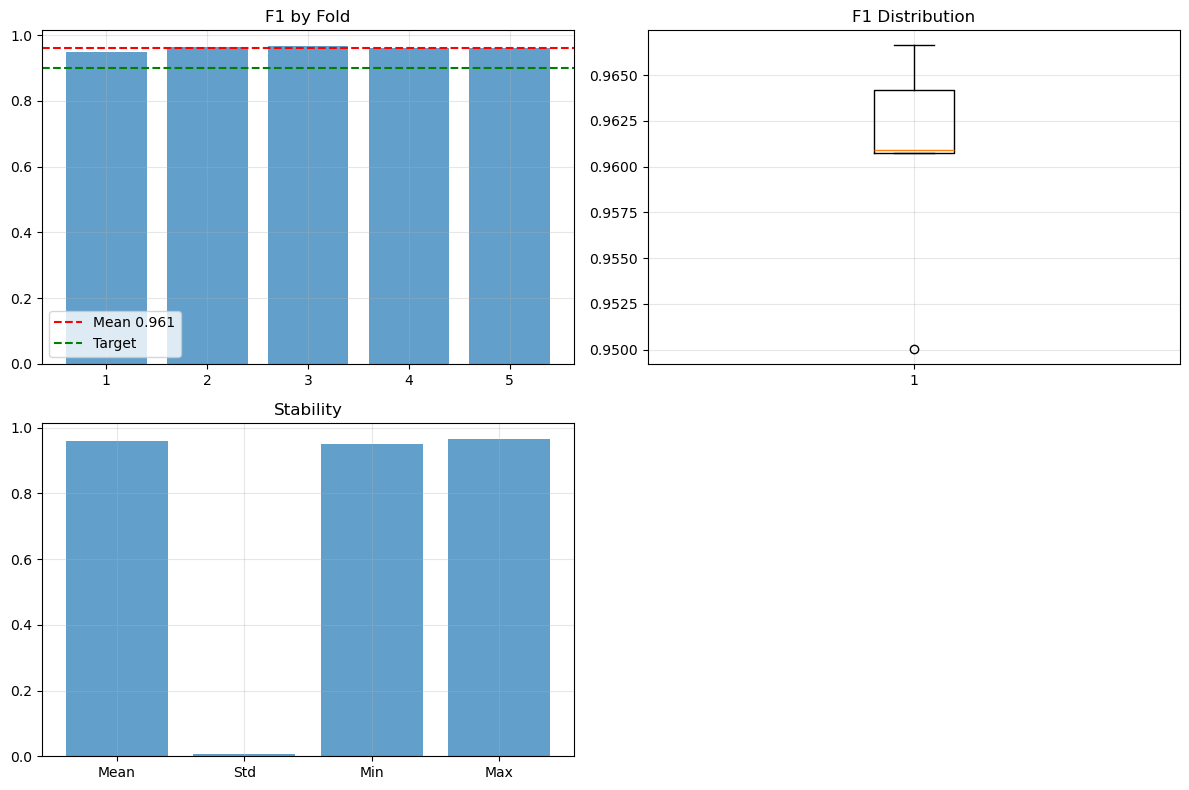

In [16]:
class CrossValidationEvaluator:
    def __init__(self, k_folds:int=5):
        self.k_folds = k_folds
        self.results = []

    def evaluate_all_folds(self):
        scores = []
        for fold in range(1, self.k_folds+1):
            try:
                td = json.load(open(f'../data/fold_{fold}_train.json','r',encoding='utf-8'))
                vd = json.load(open(f'../data/fold_{fold}_val.json','r',encoding='utf-8'))
            except FileNotFoundError:
                print(f"⚠️ Fold {fold} missing, skip")
                continue

            Xtr_t, Ytr_l = tokenizer.preprocess_for_training(td)
            Xvl_t, Yvl_l = tokenizer.preprocess_for_training(vd)
            Xtr_f, Ytr_e = feature_extractor.prepare_training_data(Xtr_t, Ytr_l)
            Xvl_f, Yvl_e = feature_extractor.prepare_training_data(Xvl_t, Yvl_l)

            mdl = type(best_model)(**best_model.get_params())
            mdl.fit(Xtr_f, Ytr_e)
            pred = mdl.predict(Xvl_f)
            f1 = float(f1_score(Yvl_e, pred, average='weighted'))
            rep = classification_report(Yvl_e, pred,
                                        target_names=feature_extractor.label_encoder.classes_,
                                        output_dict=True, zero_division=0)
            self.results.append({'fold':fold,'f1':f1,'report':rep})
            scores.append(f1)
            print(f"Fold {fold}: F1={f1:.4f}")

        if not scores:
            return None
        mean_f1 = float(np.mean(scores))
        std_f1  = float(np.std(scores))
        print(f"\nMean F1={mean_f1:.4f} ±{std_f1:.4f}")
        return {
            'mean_f1': mean_f1,
            'std_f1': std_f1,
            'fold_scores': scores,
            'cv_stable': bool(std_f1<0.05)
        }

    def plot(self, summary:Dict[str,Any]):
        if not summary:
            print("No CV data")
            return
        plt.figure(figsize=(12,8))
        # by fold
        plt.subplot(2,2,1)
        xs = range(1,len(summary['fold_scores'])+1)
        plt.bar(xs, summary['fold_scores'], alpha=0.7)
        plt.axhline(summary['mean_f1'], ls='--', color='red', label=f"Mean {summary['mean_f1']:.3f}")
        plt.axhline(0.9, ls='--', color='green', label='Target')
        plt.title('F1 by Fold'); plt.legend(); plt.grid(alpha=0.3)
        # distribution
        plt.subplot(2,2,2)
        plt.boxplot(summary['fold_scores'])
        plt.title('F1 Distribution'); plt.grid(alpha=0.3)
        # stability
        plt.subplot(2,2,3)
        stats = ['Mean','Std','Min','Max']
        vals  = [summary['mean_f1'], summary['std_f1'], min(summary['fold_scores']), max(summary['fold_scores'])]
        plt.bar(stats, vals, alpha=0.7)
        plt.title('Stability'); plt.grid(alpha=0.3)
        plt.tight_layout(); plt.show()

cv_eval = CrossValidationEvaluator(k_folds=5)
cv_summary = cv_eval.evaluate_all_folds()
if cv_summary:
    cv_eval.plot(cv_summary)
else:
    print("⚠️ No CV performed")

## 3. Error Analysis & False Positives/Negatives

FP: 20, FN: 10


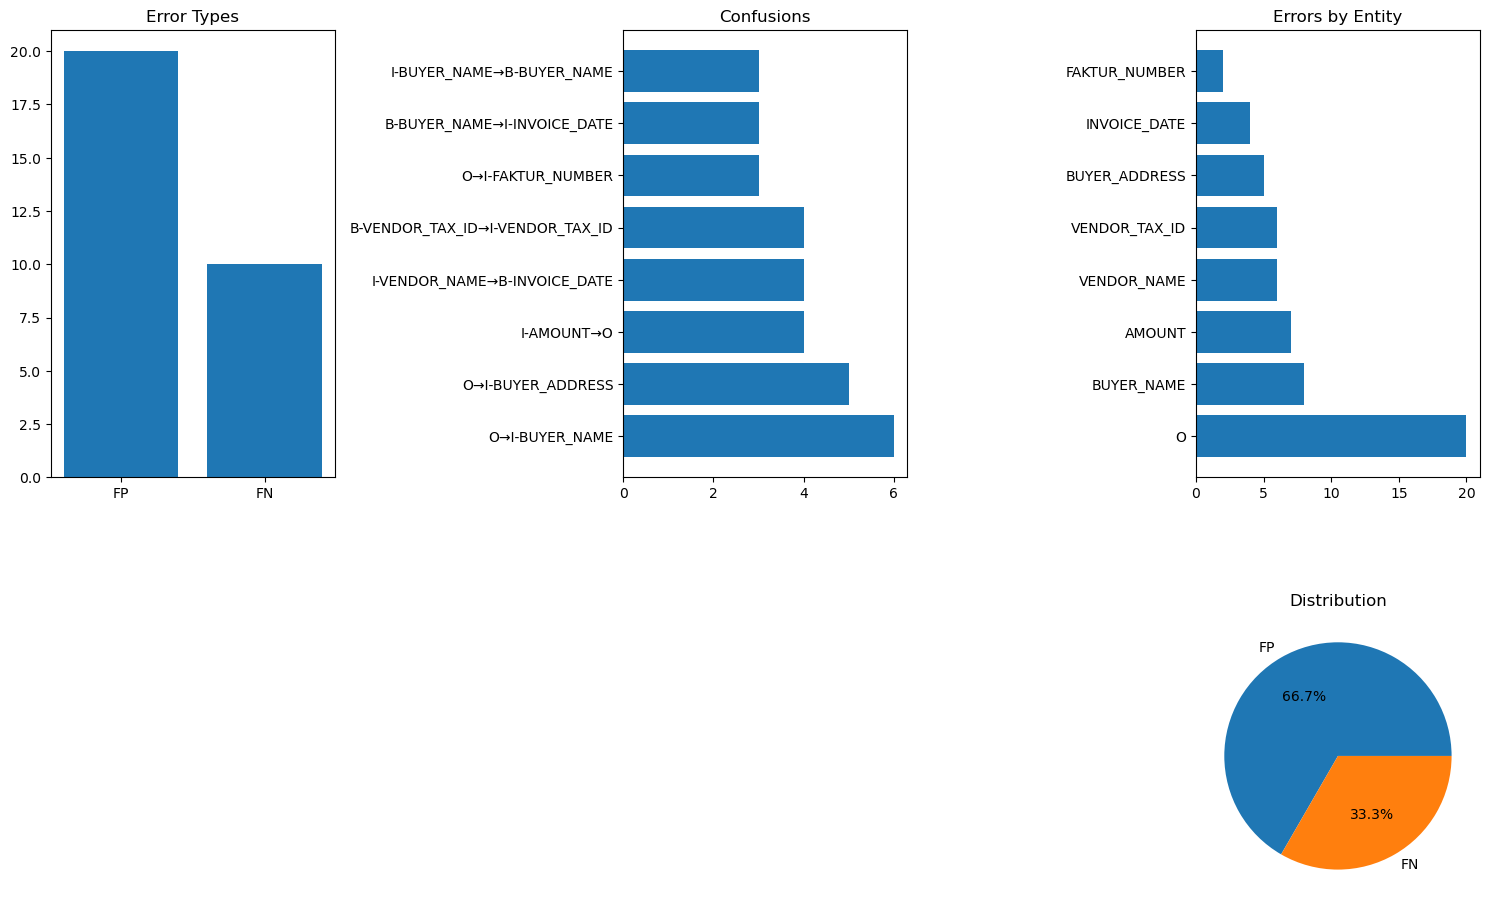

In [17]:

class ErrorAnalyzer:
    def __init__(self, model, fe, tk):
        self.model = model
        self.fe = fe
        self.tk = tk
        self.analysis = {}

    def analyze(self, data:List[Dict[str,Any]], sample_size:int=100):
        n = min(sample_size, len(data))
        X_t, Y_l = self.tk.preprocess_for_training(data[:n])
        X_f, Y_e = self.fe.prepare_training_data(X_t, Y_l)
        pred = self.model.predict(X_f)
        true_lbls = self.fe.label_encoder.inverse_transform(Y_e)
        pred_lbls = self.fe.label_encoder.inverse_transform(pred)

        errs = {'fp':[], 'fn':[], 'conf':{}, 'by_entity':{}}
        idx=0
        for si, toks in enumerate(X_t):
            for pos, tl in enumerate(Y_l[si]):
                if idx>=len(pred_lbls): break
                pl = pred_lbls[idx]
                if tl!=pl:
                    info = {'sample':si,'token':toks[pos],'pos':pos,'true':tl,'pred':pl,
                            'ctx':' '.join(toks[max(0,pos-2):pos+3])}
                    if tl=='O' and pl!='O':
                        errs['fp'].append(info)
                    elif tl!='O' and pl=='O':
                        errs['fn'].append(info)
                    pair=(tl,pl)
                    errs['conf'][pair]=errs['conf'].get(pair,0)+1
                    ent = tl.split('-')[-1] if '-' in tl else tl
                    errs['by_entity'].setdefault(ent,[]).append(info)
                idx+=1
        self.analysis=errs
        print(f"FP: {len(errs['fp'])}, FN: {len(errs['fn'])}")
        return errs

    def plot(self):
        e = self.analysis
        if not e:
            print("No error data"); return
        plt.figure(figsize=(15,10))
        # types
        plt.subplot(2,3,1)
        cnts=[len(e['fp']),len(e['fn'])]
        plt.bar(['FP','FN'],cnts); plt.title('Error Types')
        # confusions
        plt.subplot(2,3,2)
        top=sorted(e['conf'].items(),key=lambda x:x[1],reverse=True)[:8]
        if top:
            labs=[f"{p[0]}→{p[1]}" for p,_ in top]; vals=[c for _,c in top]
            plt.barh(labs,vals); plt.title('Confusions')
        # by entity
        plt.subplot(2,3,3)
        entc=sorted([(k,len(v)) for k,v in e['by_entity'].items()],key=lambda x:x[1],reverse=True)[:8]
        if entc:
            ents=[x[0] for x in entc]; vs=[x[1] for x in entc]
            plt.barh(ents,vs); plt.title('Errors by Entity')
        # pie
        plt.subplot(2,3,6)
        if sum(cnts)>0:
            plt.pie(cnts,labels=['FP','FN'],autopct='%1.1f%%'); plt.title('Distribution')
        plt.tight_layout(); plt.show()

with open('../data/augmented_dataset.json','r',encoding='utf-8') as f:
    test_data = json.load(f)
err_an = ErrorAnalyzer(best_model, feature_extractor, tokenizer)
err_res = err_an.analyze(test_data, sample_size=100)
err_an.plot()


## 4. Post-Processing & Data Normalization Validation


In [18]:
class PostProcessingValidator:
    def __init__(self):
        self.rules = {
            'date_formats':['%d/%m/%Y','%d-%m-%Y','%Y-%m-%d','%d %b %Y'],
            'currency':['Rp','IDR','Rupiah'],
            'npwp_pat':r'\d{2}\.\d{3}\.\d{3}\.\d{1}-\d{3}\.\d{3}'
        }
    def normalize_date(self,d:str)->str:
        if not d.strip(): return ''
        for pat,fmt in [(r'(\d{1,2})[\/\-](\d{1,2})[\/\-](\d{4})','%d/%m/%Y'),
                        (r'(\d{4})[\/\-](\d{1,2})[\/\-](\d{1,2})','%Y/%m/%d')]:
            m=re.search(pat,d)
            if m:
                g=m.groups()
                if fmt=='%d/%m/%Y': return f"{g[2]}-{g[1].zfill(2)}-{g[0].zfill(2)}"
                if fmt=='%Y/%m/%d': return f"{g[0]}-{g[1].zfill(2)}-{g[2].zfill(2)}"
        return d
    def normalize_currency(self,a:str)->str:
        if not a.strip(): return ''
        c=a
        for s in self.rules['currency']: c=c.replace(s,'').replace('.','').strip()
        nums=re.findall(r'[\d,]+',c)
        return nums[0].replace(',','') if nums else a
    def normalize_npwp(self,n:str)->str:
        if not n.strip(): return ''
        digits=re.sub(r'\D','',n)
        if len(digits)==15:
            return f"{digits[:2]}.{digits[2:5]}.{digits[5:8]}.{digits[8]}-{digits[9:12]}.{digits[12:15]}"
        return n
    def validate(self,samps:List[Dict[str,Any]]):
        res={'date':[],'currency':[],'npwp':[],'success':0}
        ok,tot=0,0
        for s in samps:
            if 'invoice_date'in s:
                o=s['invoice_date']; n=self.normalize_date(o)
                res['date'].append({'orig':o,'norm':n,'ok':bool(n!=o and re.match(r'\d{4}-\d{2}-\d{2}',n))})
                tot+=1; ok+=int(n!=o)
            if 'invoice_total'in s:
                o=s['invoice_total']; n=self.normalize_currency(o)
                res['currency'].append({'orig':o,'norm':n,'ok':bool(n!=o and n.isdigit())})
                tot+=1; ok+=int(n!=o)
            if 'vendor'in s and 'tax_id'in s['vendor']:
                o=s['vendor']['tax_id']; n=self.normalize_npwp(o)
                res['npwp'].append({'orig':o,'norm':n,'ok':bool(n!=o and re.match(self.rules['npwp_pat'],n))})
                tot+=1; ok+=int(n!=o)
        res['success']=float(ok/tot) if tot>0 else 0.0
        print(f"Normalization success: {res['success']:.2%}")
        return res
    def demo(self,r):
        print("\nExamples:")
        for key,icon in [('date','📅'),('currency','💰'),('npwp','🏢')]:
            if r[key]:
                print(f"\n{icon} {key.capitalize()}:")
                for ex in r[key][:3]:
                    mark='✅' if ex['ok'] else '➡️'
                    print(f"  {mark} {ex['orig']} → {ex['norm']}")

samples = [
    {'invoice_date':'15/03/2024','invoice_total':'Rp 500,000','vendor':{'tax_id':'01000000100000'}},
    {'invoice_date':'20-04-2024','invoice_total':'IDR 1.250.000','vendor':{'tax_id':'02.345.678.9-012.345'}},
    {'invoice_date':'2024/05/10','invoice_total':'750000','vendor':{'tax_id':'03.456.789.0-123.456'}}
]
ppv = PostProcessingValidator()
vres = ppv.validate(samples)
ppv.demo(vres)


Normalization success: 55.56%

Examples:

📅 Date:
  ✅ 15/03/2024 → 2024-03-15
  ✅ 20-04-2024 → 2024-04-20
  ✅ 2024/05/10 → 2024-05-10

💰 Currency:
  ✅ Rp 500,000 → 500000
  ✅ IDR 1.250.000 → 1250000
  ➡️ 750000 → 750000

🏢 Npwp:
  ➡️ 01000000100000 → 01000000100000
  ➡️ 02.345.678.9-012.345 → 02.345.678.9-012.345
  ➡️ 03.456.789.0-123.456 → 03.456.789.0-123.456


## 5. Final Evaluation Report


In [19]:
# Build Python-native report
final_report = {
    'model_performance': {
        'best_model': training_summary['best_model']['name'],
        'best_f1': float(training_summary['best_model']['f1_score']),
        'target_met': bool(training_summary['best_model']['f1_score'] > 0.9),
        'iterations': int(training_summary['total_iterations'])
    },
    'cross_validation': {
        'mean_f1': float(cv_summary['mean_f1']) if cv_summary else None,
        'std_f1':  float(cv_summary['std_f1']) if cv_summary else None,
        'cv_stable': bool(cv_summary['cv_stable']) if cv_summary else None
    },
    'error_analysis': {
        'total_errors': int(len(err_res['fp']) + len(err_res['fn'])),
        'false_positive_rate': float(len(err_res['fp']) / (len(err_res['fp']) + len(err_res['fn']))) 
                               if (len(err_res['fp']) + len(err_res['fn']))>0 else 0.0,
        'top_entities': [(k,int(len(v))) for k,v in sorted(err_res['by_entity'].items(), key=lambda x:len(x[1]), reverse=True)[:5]]
    },
    'post_processing': {
        'success_rate': float(vres['success']),
        'date_norm': bool(vres['date']),
        'currency_norm': bool(vres['currency']),
        'npwp_norm': bool(vres['npwp'])
    },
    'production_readiness': {
        'f1_ok': bool(training_summary['best_model']['f1_score'] > 0.9),
        'iters_ok': bool(training_summary['total_iterations'] >= 20),
        'cv_ok': bool(cv_summary and cv_summary['cv_stable']),
        'errors_analyzed': True,
        'post_validated': True
    },
    'recommendations': [],
    'evaluation_date': datetime.now().isoformat()
}

# Recommendations
recs = []
if not final_report['production_readiness']['f1_ok']:
    recs.append("Add more data/features to exceed 0.9 F1")
if err_res['fp']:
    recs.append("Tighten post-processing to reduce false positives")
if err_res['fn']:
    recs.append("Augment training set for frequent false-negative entities")
if final_report['post_processing']['success_rate'] < 0.5:
    recs.append("Improve normalization rules for higher success")
if cv_summary and not cv_summary['cv_stable']:
    recs.append("Address fold variance via regularization or more data")
recs += [
    "Leverage actual document coordinates for layout features",
    "Enhance Indonesian linguistic features",
    "Implement active learning for continuous improvement"
]
final_report['recommendations'] = recs

# Save JSON-safe
with open('../models/evaluation_report.json','w',encoding='utf-8') as f:
    json.dump(final_report, f, ensure_ascii=False, indent=2)

# Print summary
print("📋 FINAL EVALUATION REPORT")
print("="*30)
mp = final_report['model_performance']
print(f"Model: {mp['best_model']} | F1: {mp['best_f1']:.4f} | Target Met: {mp['target_met']}")
if cv_summary:
    cv = final_report['cross_validation']
    print(f"CV Mean F1: {cv['mean_f1']:.4f} ±{cv['std_f1']:.4f} | Stable: {cv['cv_stable']}")
ea = final_report['error_analysis']
print(f"Errors: {ea['total_errors']} | FP Rate: {ea['false_positive_rate']:.1%}")
pp = final_report['post_processing']
print(f"Normalization Success: {pp['success_rate']:.1%}")
print("\nRecommendations:")
for i,r in enumerate(recs,1):
    print(f" {i}. {r}")
print(f"\nReport saved to ../models/evaluation_report.json")

📋 FINAL EVALUATION REPORT
Model: Gradient Boosting | F1: 0.9620 | Target Met: True
CV Mean F1: 0.9605 ±0.0057 | Stable: True
Errors: 30 | FP Rate: 66.7%
Normalization Success: 55.6%

Recommendations:
 1. Tighten post-processing to reduce false positives
 2. Augment training set for frequent false-negative entities
 3. Leverage actual document coordinates for layout features
 4. Enhance Indonesian linguistic features
 5. Implement active learning for continuous improvement

Report saved to ../models/evaluation_report.json
